In [1]:
import numpy as np
import os
os.chdir('/home/ia404/gitreps/dustbias/mbatch/')
import argparse
from utils import get_auto_name, bandedcls, get_dust_name, get_auto_name, get_norm_name, get_px_frommask, get_noise_dict_name, get_dust_2pt_name
from orphics import stats, maps
from sofind import DataModel
import pytempura
from solenspipe.utility import w_n
from pixell import enmap, curvedsky as cs
from falafel import utils as futils, qe
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib import rcParams
rcParams['font.size']=20
rcParams['axes.linewidth']=1.5
rcParams['xtick.major.width']=1.5
rcParams['xtick.minor.width']=1
rcParams['ytick.major.width']=1.5
rcParams['ytick.minor.width']=1
rcParams['xtick.major.pad']='8'
rcParams['xtick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.direction'] = 'in'
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True
rcParams['ytick.right'] = True
rcParams['text.usetex'] = True
rcParams['font.family'] = 'Helvetica'

%matplotlib inline

--------------------------------------------------------------------------

  Local host:   login-q-3
  Local device: mlx5_0
--------------------------------------------------------------------------


In [3]:
args = argparse.Namespace()

In [4]:
args.config_name='act_dr6v4'
args.mask_type = 'wide_v4_20220316'
args.mask_subproduct = 'lensing_masks'
args.skyfrac = 'GAL070'
args.apodfact = '3dg'
args.mlmax=4000
args.lmax=3000
args.lmin=600
args.filter_whiteamplitude=12.
args.filter_whitefwhm=1.4
args.tilt = -0.8
args.amplitude = 119.47982655
args.est= 'TT'
args.dust_type='gauss'

In [5]:
path = f'/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/mbatch_gauss/'
data_path = lambda x: os.path.join(path, x)

In [6]:
# signal
lk, clkk=np.loadtxt('/rds/project/dirac_vol5/rds-dirac-dp002/ia404/sslp/extra/clkk_raw_plikHM_TTTEEE_lowl_lowE_dr6_accuracy.txt',unpack=True)
clpp = clkk * 4 / (lk * (lk+1))**2

/tmp/ipykernel_3901989/621840297.py:3: RuntimeWarning: invalid value encountered in divide
  clpp = clkk * 4 / (lk * (lk+1))**2


In [79]:
ell_arr = np.arange(args.mlmax+1)
lfac =  (ell_arr * (ell_arr + 1))**2 / (2 * np.pi)
lfac_2pt = ell_arr * (ell_arr + 1)
# lcut = 500
# nbands = 100

lcut = 50
nbands_log = 50
nbands_lin = 7
lbands = np.concatenate((np.linspace(2, lcut, nbands_lin, dtype=int)[:-1], np.logspace(np.log10(lcut), np.log10(args.mlmax), nbands_log+1, dtype=int)))

#lbands = np.asarray([40, 66, 101, 145, 199, 264, 339, 426, 526, 638, 763])   # np.concatenate((np.linspace(2, lcut)[:-1], np.logspace(np.log10(lcut), np.log10(args.mlmax), nbands+1)))#  dtype=int)

In [8]:
ucls, _ = futils.get_theory_dicts(nells=None, lmax=args.mlmax, grad=True)
filters = futils.get_theory_dicts_white_noise(args.filter_whitefwhm, args.filter_whiteamplitude, lmax=args.mlmax, grad=False)[1]
Als = np.load(data_path(f'stage_filter/{get_norm_name(args)}'), allow_pickle=True).item()

In [9]:
cl_2pt_tcls = {}
cl_fg = np.loadtxt(data_path(f'stage_dust_data/{get_dust_2pt_name(args, sim=1000, fsky=args.skyfrac)}'))
cl_tot = filters[args.est]
cl_2pt_tcls[args.est] = cl_tot**2 / cl_fg

In [10]:
Al_dust_N0_TT = pytempura.get_norms([args.est], ucls, ucls, cl_2pt_tcls, args.lmin, args.lmax, k_ellmax=args.mlmax, profile=None)
N0_TT = Als[args.est][0]**2 / Al_dust_N0_TT[args.est][0]

use new TT


/tmp/ipykernel_3901989/1503640851.py:2: RuntimeWarning: invalid value encountered in divide
  N0_TT = Als[args.est][0]**2 / Al_dust_N0_TT[args.est][0]


In [11]:
cls_4pt = np.loadtxt(data_path(f'stage_auto_{args.skyfrac}/{get_auto_name(args, mf=True)}'))
cls_4pt_noise0 = np.loadtxt(data_path(f'stage_auto_{args.skyfrac}/{get_auto_name(args, mf=True, tag="set00")}'))
cls_4pt_nomf = np.loadtxt(data_path(f'stage_auto_{args.skyfrac}/{get_auto_name(args, mf=False)}'))

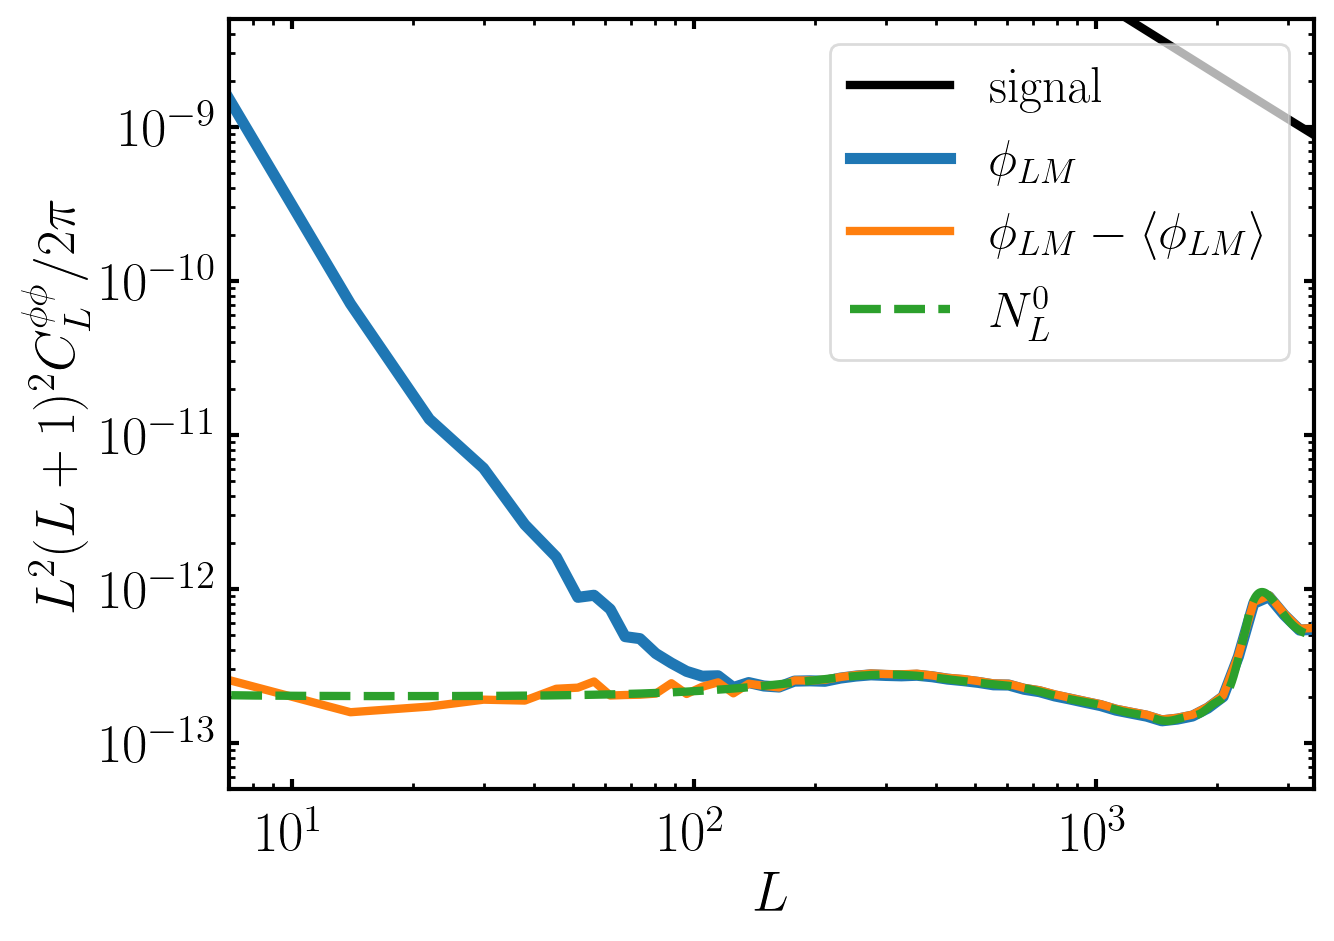

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(7,5), dpi = 200)

ax.loglog(ell_arr[2:], (clpp[:args.mlmax+1]*lfac)[2:], linestyle = 'solid', color ='k', linewidth = 3, label=r'$\mathrm{signal}$')

bin_ell, bin_cell = bandedcls(cls_4pt_nomf[:args.mlmax+1] * lfac, lbands)
ax.loglog(bin_ell, bin_cell,'-', lw=4, label=r'$\phi_{LM}$') #color='cornflowerblue', 

bin_ell, bin_cell = bandedcls(cls_4pt[:args.mlmax+1] * lfac, lbands)
ax.loglog(bin_ell, bin_cell,'-', lw=3,  label=r'$\phi_{LM} - \left<\phi_{LM}\right>$') # color='crimson',
#ax.loglog(ell_arr[2:], (cls_4pt_nomf[:args.mlmax+1]*lfac)[2:], linestyle = 'solid', color ='k', linewidth = 3, label='theory phiphi signal')
#ax.loglog(ell_arr[2:], (cls_4pt[:args.mlmax+1]*lfac)[2:], linestyle = 'solid', color ='k', linewidth = 3, label='theory phiphi signal')


ax.loglog(ell_arr[2:], (N0_TT[:args.mlmax+1]*lfac)[2:], linestyle = 'dashed', linewidth = 3, label=r'$N_L^0$') # color ='forestgreen', 
ax.set_xlim(7, 3500)
ax.set_ylim(5e-14, 5e-9)
#ax.legend(prop={'size': 12})
ax.legend(prop={'size': 18}, loc='upper right', framealpha=0.7)

ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$L^2(L+1)^2C_L^{\phi\phi}/2\pi$')

fig.savefig("/home/ia404/gitreps/dustbias/mbatch/srchardening/Figures/explain_biases_wgauss.png", bbox_inches='tight')
fig.savefig("/home/ia404/gitreps/dustbias/mbatch/srchardening/Figures/explain_biases_wgauss.pdf", bbox_inches='tight')
plt.show()